In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
import copy

In [3]:
import os, sys
sys.path.append("scripts/")

In [4]:
#see https://dtaidistance.readthedocs.io/en/latest/usage/installation.html#from-pypi and install from source
from dtaidistance import clustering
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

In [5]:
#pip install tsam
import tsam.timeseriesaggregation as tsam

In [6]:
#from ts_cluster import TSCluster

In [7]:
%matplotlib inline

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
PATH='../input/merged_data/'

### Read in Data

In [16]:
hh = pd.read_csv(PATH+'hh_melted_all.csv')

In [18]:
hh.head()

,Unnamed: 0,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,LCL_day_uid,Bank_holiday,time,energy(kWh/hh)
0,0,MAC000002,2012-10-12,0.1385,0.154304,0.886,46.0,0.196034,7.098,0.0,MAC000002_2012-10-12,NaN,00:00:00,NaN
1,1,MAC000002,2012-10-12,0.1385,0.154304,0.886,46.0,0.196034,7.098,0.0,MAC000002_2012-10-12,NaN,00:30:00,0.0
2,2,MAC000002,2012-10-12,0.1385,0.154304,0.886,46.0,0.196034,7.098,0.0,MAC000002_2012-10-12,NaN,01:00:00,0.0
3,3,MAC000002,2012-10-12,0.1385,0.154304,0.886,46.0,0.196034,7.098,0.0,MAC000002_2012-10-12,NaN,01:30:00,0.0
4,4,MAC000002,2012-10-12,0.1385,0.154304,0.886,46.0,0.196034,7.098,0.0,MAC000002_2012-10-12,NaN,02:00:00,0.0


In [19]:
macs = hh['LCLid'].unique() 

In [20]:
#number of households:
len(macs)

5567

In [21]:
informations_households = pd.read_csv(PATH+'informations_households.csv')

In [22]:
informations_households.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [23]:
acorns = informations_households['Acorn'].unique() 
#number of acorns:
len(acorns)

19

### Select houses from a particular Acorn

In [24]:
acorn_a_houses = informations_households.loc[informations_households['Acorn']=='ACORN-A']['LCLid']

In [25]:
acorn_a_hh = hh.loc[hh['LCLid'].isin(acorn_a_houses)]

In [26]:
acorn_a_hh.head()

,Unnamed: 0,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,LCL_day_uid,Bank_holiday,time,energy(kWh/hh)
0,0,MAC000002,2012-10-12,0.1385,0.154304,0.886,46.0,0.196034,7.098,0.0,MAC000002_2012-10-12,NaN,00:00:00,NaN
1,1,MAC000002,2012-10-12,0.1385,0.154304,0.886,46.0,0.196034,7.098,0.0,MAC000002_2012-10-12,NaN,00:30:00,0.0
2,2,MAC000002,2012-10-12,0.1385,0.154304,0.886,46.0,0.196034,7.098,0.0,MAC000002_2012-10-12,NaN,01:00:00,0.0
3,3,MAC000002,2012-10-12,0.1385,0.154304,0.886,46.0,0.196034,7.098,0.0,MAC000002_2012-10-12,NaN,01:30:00,0.0
4,4,MAC000002,2012-10-12,0.1385,0.154304,0.886,46.0,0.196034,7.098,0.0,MAC000002_2012-10-12,NaN,02:00:00,0.0


In [27]:
acorn_a_2d = acorn_a_hh[['LCLid','energy(kWh/hh)']]

In [28]:
acorn_a_2d.fillna(0, inplace=True)

In [29]:
acon_energy = [x['energy(kWh/hh)'] for _, x in acorn_a_2d.groupby('LCLid')]

In [30]:
type(acon_energy[1])

pandas.core.series.Series

In [32]:
#clustering code needs numpy arrays
series_data=[]
for a in acon_energy:
    series_data.append(a.values[:34000])

### Hierachical clustering

In [38]:
#even just using a single acorn took >2hrs to run cell below before stopped it, try on a subset
series_subset = series_data[1:6]

In [88]:
#TODO check why series are not all same length

In [39]:
for s in series_subset:
    print (len(s))

34000
34000
34000
34000
34000


In [40]:
# Custom Hierarchical clustering
model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})
# Augment Hierarchical object to keep track of the full tree
model2 = clustering.HierarchicalTree(model1)
# SciPy linkage clustering
model3 = clustering.LinkageTree(dtw.distance_matrix_fast, {})
cluster_idx = model3.fit(series_subset)

(None, array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3863ec5ba8>,
       dtype=object))

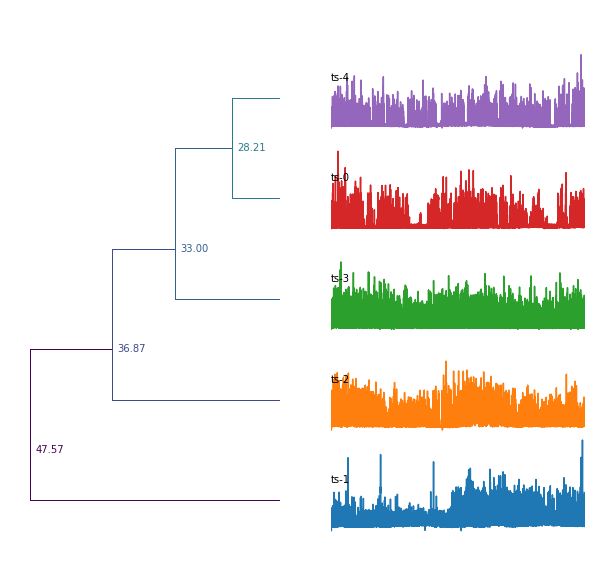

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
show_ts_label = lambda idx: "ts-" + str(idx)
model3.plot("../plots/hierarchy.png", axes=ax, show_ts_label=show_ts_label,
           show_tr_label=True, ts_label_margin=-10,
           ts_left_margin=10, ts_sample_length=1)

### Plot dynamic time warping paths between 2 consecutive days (half hourly data) for a sample household

In [36]:
MAC000002_data = hh.loc[hh['LCLid']=='MAC000002']
MAC000002_data = MAC000002_data.fillna(0, inplace=True)

In [59]:
MAC000002_data.head()

,Unnamed: 0,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,LCL_day_uid,Bank_holiday,time,energy(kWh/hh)
0,0,MAC000002,2012-10-12,0.1385,0.154304,0.886,46.0,0.196034,7.098,0.0,MAC000002_2012-10-12,NaN,00:00:00,NaN
1,1,MAC000002,2012-10-12,0.1385,0.154304,0.886,46.0,0.196034,7.098,0.0,MAC000002_2012-10-12,NaN,00:30:00,0.0
2,2,MAC000002,2012-10-12,0.1385,0.154304,0.886,46.0,0.196034,7.098,0.0,MAC000002_2012-10-12,NaN,01:00:00,0.0
3,3,MAC000002,2012-10-12,0.1385,0.154304,0.886,46.0,0.196034,7.098,0.0,MAC000002_2012-10-12,NaN,01:30:00,0.0
4,4,MAC000002,2012-10-12,0.1385,0.154304,0.886,46.0,0.196034,7.098,0.0,MAC000002_2012-10-12,NaN,02:00:00,0.0


In [28]:
MAC000002_day_1 = MAC000002_data.loc[MAC000002_data['day']=='2012-10-13']
MAC000002_day_2 = MAC000002_data.loc[MAC000002_data['day']=='2012-10-14']

In [31]:
MAC000002_day_1=MAC000002_day_1['energy(kWh/hh)'].values
MAC000002_day_2=MAC000002_day_2['energy(kWh/hh)'].values

(<Figure size 720x720 with 4 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fd2a2ea4240>])

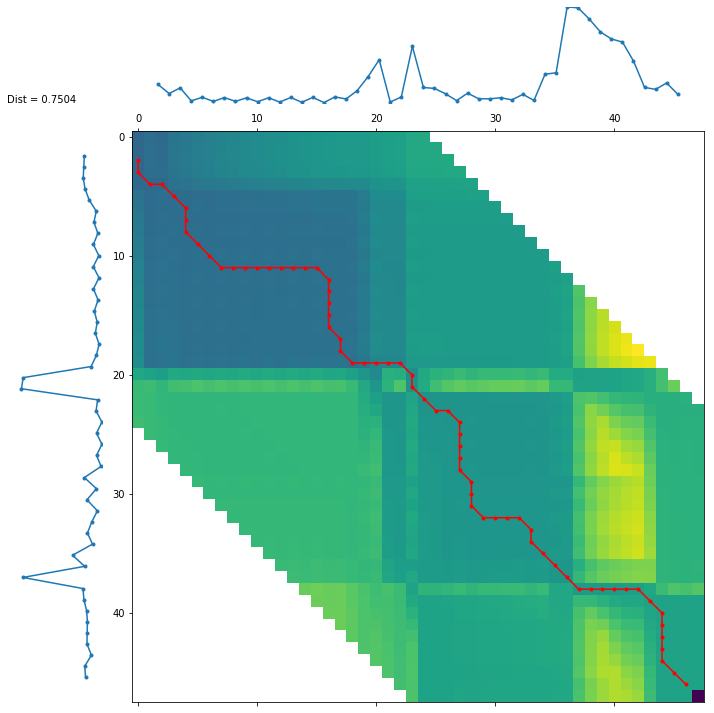

In [32]:
d, paths = dtw.warping_paths(MAC000002_day_1, MAC000002_day_2, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(MAC000002_day_1, MAC000002_day_2, paths, best_path)

### tsam

In [68]:
def plotTS(data, periodlength, vmin, vmax):
    fig, axes = plt.subplots(figsize = [14, 2], dpi = 100, nrows = 1, ncols = 1)
    stacked, timeindex = tsam.unstackToPeriods(copy.deepcopy(data), periodlength)
    cax = axes.imshow(stacked.values.T, interpolation = 'nearest', vmin = vmin, vmax = vmax)
    axes.set_aspect('auto')  
    axes.set_ylabel('Half hour')
    plt.xlabel('Day')

    fig.subplots_adjust(right = 1.2)
    cbar=plt.colorbar(cax)    
    cbar.set_label('energy(kWh/hh)')


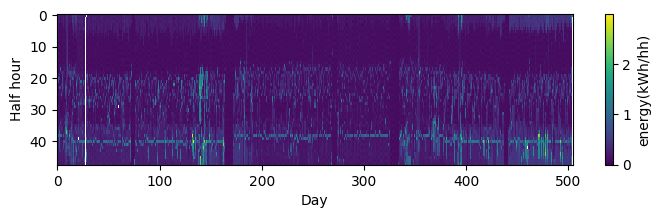

In [69]:
plotTS(MAC000002_data['energy(kWh/hh)'], 48, vmin = MAC000002_data['energy(kWh/hh)'].min(), vmax =MAC000002_data['energy(kWh/hh)'].max())

In [70]:
MAC000048_data = hh.loc[hh['LCLid']=='MAC000048']

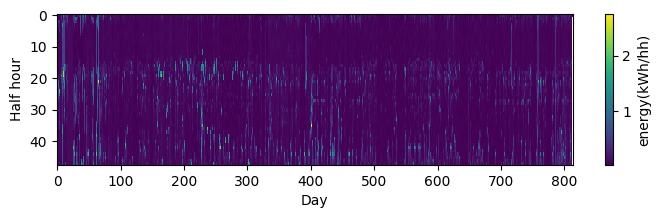

In [71]:
plotTS(MAC000048_data['energy(kWh/hh)'], 48, vmin = MAC000048_data['energy(kWh/hh)'].min(), vmax =MAC000048_data['energy(kWh/hh)'].max())

In [72]:
MAC005492_data = hh.loc[hh['LCLid']=='MAC005492']

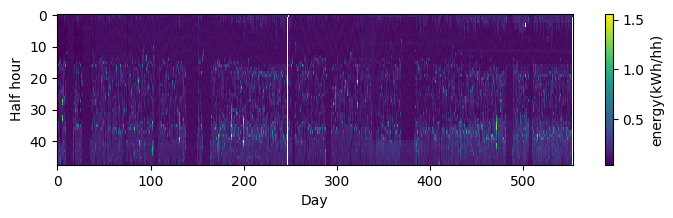

In [73]:
plotTS(MAC005492_data['energy(kWh/hh)'], 48, vmin = MAC005492_data['energy(kWh/hh)'].min(), vmax =MAC005492_data['energy(kWh/hh)'].max())